In [1]:
# ==============================================================================
# CELL 1: SETUP & IMPORTS
# ==============================================================================

import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("✅ All imports successful!")
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")


✅ All imports successful!
TensorFlow version: 2.10.0
Keras version: 2.10.0


In [2]:
# ==============================================================================
# CELL 2: PATHS & DIRECTORIES
# ==============================================================================

# Base path
BASE_PATH = r"C:\Users\paris\OneDrive\Desktop\Model_Traning\FingerSpelling"
DATASET_PATH = os.path.join(BASE_PATH, "Dataset")
FOUNDATION_PATH = os.path.join(BASE_PATH, "Foundation")

# Create output directories
MODEL_DIR = os.path.join(FOUNDATION_PATH, "models")
LOGS_DIR = os.path.join(FOUNDATION_PATH, "logs")
DATA_DIR = os.path.join(FOUNDATION_PATH, "data")

for dir_path in [MODEL_DIR, LOGS_DIR, DATA_DIR]:
    os.makedirs(dir_path, exist_ok=True)

# Word mapping
WORD_MAP = {
    0: "BLANK",
    1: "GOOD",
    2: "HELLO",
    3: "HOW",
    4: "MORNING",
    5: "NIGHT",
    6: "OK",
    7: "YOU"
}

REVERSE_WORD_MAP = {v: k for k, v in WORD_MAP.items()}

# Dataset structure
DATASET_FOLDERS = {
    1: "Good",
    2: "Hello",
    3: "How",
    4: "Morning",
    5: "Night",
    6: "ok",
    7: "You"
}

print("="*80)
print("PATHS CONFIGURED")
print("="*80)
print(f"Base Path:     {BASE_PATH}")
print(f"Dataset Path:  {DATASET_PATH}")
print(f"Models Path:   {MODEL_DIR}")
print(f"Logs Path:     {LOGS_DIR}")
print(f"Data Path:     {DATA_DIR}")
print("="*80)

# Verify directories exist
for word_id, folder_name in DATASET_FOLDERS.items():
    folder_path = os.path.join(DATASET_PATH, folder_name)
    if os.path.exists(folder_path):
        file_count = len(os.listdir(folder_path))
        print(f"✅ {folder_name:10s} ({word_id}): {file_count} files")
    else:
        print(f"❌ {folder_name:10s} ({word_id}): NOT FOUND")


PATHS CONFIGURED
Base Path:     C:\Users\paris\OneDrive\Desktop\Model_Traning\FingerSpelling
Dataset Path:  C:\Users\paris\OneDrive\Desktop\Model_Traning\FingerSpelling\Dataset
Models Path:   C:\Users\paris\OneDrive\Desktop\Model_Traning\FingerSpelling\Foundation\models
Logs Path:     C:\Users\paris\OneDrive\Desktop\Model_Traning\FingerSpelling\Foundation\logs
Data Path:     C:\Users\paris\OneDrive\Desktop\Model_Traning\FingerSpelling\Foundation\data
✅ Good       (1): 102 files
✅ Hello      (2): 113 files
✅ How        (3): 102 files
✅ Morning    (4): 106 files
✅ Night      (5): 102 files
✅ ok         (6): 107 files
✅ You        (7): 102 files


In [3]:
# ==============================================================================
# CELL 3: LOAD DATASET (JSON WITH YOUR PREPROCESSING)
# ==============================================================================

import json
import numpy as np

# Your exact preprocessing functions
def unsigned_to_signed(unsigned_value):
    """Convert unsigned 16-bit to signed 16-bit"""
    if unsigned_value & 0x8000:
        signed_value = -((~unsigned_value & 0xFFFF) + 1)
    else:
        signed_value = unsigned_value
    return signed_value

def scale_and_normalize(input_list):
    """Scale and normalize IMU data (YOUR EXACT FUNCTION)"""
    values = [unsigned_to_signed(x) for x in input_list]
    values = np.array(values)
    scaled_value = np.zeros((int(len(input_list) / 36), 36))
    normalized_value = np.zeros((int(len(input_list) / 36), 36))
    
    accel_sensitivity = 4096 * 4  # for 8g
    gyro_sensitivity = 131         # for 1000 dps
    
    # Fixed list1 (accel indices) - you need to define this!
    list1 = [0,1,2,12,13,14,24,25,26,36,37,38,48,49,50,60,61,62]  # Adjust if needed
    
    ii = 0
    for j in range(int(len(input_list) / 36)):
        scaled_values = np.zeros(36)
        normalized_values = np.zeros(36)
        for i in range(36):
            if i in list1:
                val = values[ii] / accel_sensitivity
                scaled_values[i] = val
                normalized_values[i] = (val / 4.1) + 0.5
                ii += 1
            else:
                val = values[ii] / gyro_sensitivity
                scaled_values[i] = val
                normalized_values[i] = (val / 500.28) + 0.5
                ii += 1
        scaled_value[j] = scaled_values
        normalized_value[j] = normalized_values
    
    return scaled_value, normalized_value

def dict_in_op_out(dicc_path):
    """YOUR EXACT JSON PROCESSING FUNCTION"""
    try:
        with open(dicc_path, 'r') as f:
            dicc = json.load(f)
        
        test = []
        i = 0
        
        # Process left hand
        l1 = dicc['gesture_recording']['leftHandDataList']
        while i < 6:
            if i < len(l1[0]) and len(l1[0][i]) == 36:
                l1[0] = l1[0][i:]
                break
            else:
                i += 1
        
        if i >= 6 or l1.count(0) > 250:
            return None
        
        l2 = [item for sublist in l1[0] for item in sublist]
        scaled_l2, normalized_l2 = scale_and_normalize(l2)
        
        # Process right hand
        i = 0
        l3 = dicc['gesture_recording']['rightHandDataList']
        while i < 6:
            if i < len(l3[0]) and len(l3[0][i]) == 36:
                l3[0] = l3[0][i:]
                break
            else:
                i += 1
        
        if i >= 6 or l3.count(0) > 250:
            return None
        
        l4 = [item for sublist in l3[0] for item in sublist]
        scaled_l4, normalized_l4 = scale_and_normalize(l4)
        
        # Align and concatenate
        length = np.min((len(normalized_l2), len(normalized_l4)))
        if length < 10:
            return None
        
        normalized_l2 = normalized_l2[:length]
        normalized_l4 = normalized_l4[:length]
        normalized_l2 = np.reshape(normalized_l2, (length, 36))    
        normalized_l4 = np.reshape(normalized_l4, (length, 36))
        finale = np.concatenate((normalized_l2, normalized_l4), axis=1)
        
        test.append(finale)
        return test
        
    except Exception as e:
        print(f"Error processing {dicc_path}: {e}")
        return None

def normalize_sequence(data, target_length=720):
    """Normalize to fixed length (720 timesteps, 72 features)"""
    if data is None or len(data) == 0:
        return None
    
    current_length = len(data)
    
    if current_length > target_length:
        # Downsample
        indices = np.linspace(0, current_length - 1, target_length, dtype=int)
        return data[indices]
    elif current_length < target_length:
        # Pad with mean values
        pad_length = target_length - current_length
        pad_value = np.mean(data, axis=0)
        padding = np.tile(pad_value, (pad_length, 1))
        return np.vstack([data, padding])
    return data

def load_word_samples(word_id, folder_name):
    """Load all samples for a specific word using your preprocessing"""
    folder_path = os.path.join(DATASET_PATH, folder_name)
    samples = []
    
    if not os.path.exists(folder_path):
        print(f"❌ Folder not found: {folder_path}")
        return samples
    
    json_files = [f for f in os.listdir(folder_path) if f.endswith('.json')]
    
    for file in json_files:
        file_path = os.path.join(folder_path, file)
        raw_data = dict_in_op_out(file_path)
        
        if raw_data is not None and len(raw_data) > 0:
            # raw_data is list of [timesteps, 72]
            data = raw_data[0]  # Take first (and only) sample
            
            # Normalize to exactly (720, 72)
            normalized = normalize_sequence(data, target_length=720)
            
            if normalized is not None and normalized.shape == (720, 72):
                samples.append(normalized)
    
    return np.array(samples)

# Load all word samples
print("\n" + "="*80)
print("LOADING DATASET WITH YOUR PREPROCESSING")
print("="*80 + "\n")

word_samples = {}

for word_id, folder_name in DATASET_FOLDERS.items():
    samples = load_word_samples(word_id, folder_name)
    word_samples[word_id] = samples
    
    status = "✅" if len(samples) > 0 else "❌"
    print(f"{status} {folder_name:10s} (ID: {word_id}): {len(samples):3d} samples | Shape: {samples.shape if len(samples) > 0 else 'Empty'}")

print("\n" + "="*80)
print("DATASET LOADED SUCCESSFULLY")
print("="*80)

total_samples = sum(len(s) for s in word_samples.values())
print(f"\n✅ Total samples loaded: {total_samples}")
print(f"✅ Samples per word: {[len(word_samples[i]) for i in range(1, 8)]}")



LOADING DATASET WITH YOUR PREPROCESSING

✅ Good       (ID: 1): 102 samples | Shape: (102, 720, 72)
✅ Hello      (ID: 2): 113 samples | Shape: (113, 720, 72)
✅ How        (ID: 3): 102 samples | Shape: (102, 720, 72)
✅ Morning    (ID: 4): 106 samples | Shape: (106, 720, 72)
✅ Night      (ID: 5): 102 samples | Shape: (102, 720, 72)
✅ ok         (ID: 6): 107 samples | Shape: (107, 720, 72)
✅ You        (ID: 7): 102 samples | Shape: (102, 720, 72)

DATASET LOADED SUCCESSFULLY

✅ Total samples loaded: 734
✅ Samples per word: [102, 113, 102, 106, 102, 107, 102]


In [4]:
# ==============================================================================
# CELL 4: PHASE 2 - CREATE MULTI-WORD DATASET
# ==============================================================================

print("\n" + "="*80)
print("PHASE 2: CREATING MULTI-WORD DATASET")
print("="*80 + "\n")

# Verify we have data
word_samples_filtered = {k: v for k, v in word_samples.items() if len(v) > 0}

if not word_samples_filtered:
    print("❌ ERROR: No samples loaded! Cannot proceed.")
    print("Please verify JSON files exist in:")
    for word_id, folder_name in DATASET_FOLDERS.items():
        print(f"  - {os.path.join(DATASET_PATH, folder_name)}")
else:
    # Get minimum samples per word
    min_samples = min(len(samples) for samples in word_samples_filtered.values())
    print(f"Minimum samples per word: {min_samples}\n")
    
    # Balance sampling
    for word_id in word_samples_filtered:
        if len(word_samples_filtered[word_id]) > min_samples:
            word_samples_filtered[word_id] = word_samples_filtered[word_id][:min_samples]
    
    print(f"After balancing:")
    for word_id, samples in word_samples_filtered.items():
        print(f"  Word {word_id} ({WORD_MAP[word_id]:10s}): {len(samples)} samples")
    
    # Create single-word dataset
    print(f"\nCreating single-word training data...")
    X_single = []
    y_single = []
    
    for word_id, samples in word_samples_filtered.items():
        for sample in samples:
            X_single.append(sample)
            y_single.append([word_id, 0, 0, 0])
    
    X_single = np.array(X_single)
    y_single = np.array(y_single)
    
    print(f"✅ Single-word dataset: {X_single.shape[0]} samples | Shape: {X_single.shape}")
    
    # Create 2-word combinations
    print(f"\nCreating 2-word combinations...")
    X_2word = []
    y_2word = []
    
    num_2word_per_combo = 3
    word_ids = list(word_samples_filtered.keys())
    
    for word_id_1 in word_ids:
        for word_id_2 in word_ids:
            for _ in range(num_2word_per_combo):
                idx1 = np.random.randint(0, len(word_samples_filtered[word_id_1]))
                idx2 = np.random.randint(0, len(word_samples_filtered[word_id_2]))
                
                sample1 = word_samples_filtered[word_id_1][idx1]
                sample2 = word_samples_filtered[word_id_2][idx2]
                
                combined = np.vstack([sample1, sample2])
                combined = normalize_sequence(combined, target_length=720)
                
                X_2word.append(combined)
                y_2word.append([word_id_1, word_id_2, 0, 0])
    
    X_2word = np.array(X_2word)
    y_2word = np.array(y_2word)
    
    print(f"✅ 2-word dataset: {X_2word.shape[0]} samples | Combinations: {len(word_ids)**2 * num_2word_per_combo}")
    
    # Create 3-word combinations
    print(f"\nCreating 3-word combinations...")
    X_3word = []
    y_3word = []
    
    num_3word_per_combo = 2
    
    for word_id_1 in word_ids:
        for word_id_2 in word_ids:
            for word_id_3 in word_ids:
                for _ in range(num_3word_per_combo):
                    idx1 = np.random.randint(0, len(word_samples_filtered[word_id_1]))
                    idx2 = np.random.randint(0, len(word_samples_filtered[word_id_2]))
                    idx3 = np.random.randint(0, len(word_samples_filtered[word_id_3]))
                    
                    sample1 = word_samples_filtered[word_id_1][idx1]
                    sample2 = word_samples_filtered[word_id_2][idx2]
                    sample3 = word_samples_filtered[word_id_3][idx3]
                    
                    combined = np.vstack([sample1, sample2, sample3])
                    combined = normalize_sequence(combined, target_length=720)
                    
                    X_3word.append(combined)
                    y_3word.append([word_id_1, word_id_2, word_id_3, 0])
    
    X_3word = np.array(X_3word)
    y_3word = np.array(y_3word)
    
    print(f"✅ 3-word dataset: {X_3word.shape[0]} samples | Combinations: {len(word_ids)**3 * num_3word_per_combo}")
    
    # Combine all
    print(f"\nCombining all datasets...")
    X_phase2 = np.concatenate([X_single, X_2word, X_3word], axis=0)
    y_phase2 = np.concatenate([y_single, y_2word, y_3word], axis=0)
    
    print(f"✅ Combined: {X_phase2.shape[0]} samples")
    
    # Train-val-test split
    print(f"\nSplitting dataset (85-15 then 85-15)...")
    X_train_p2, X_test_p2, y_train_p2, y_test_p2 = train_test_split(
        X_phase2, y_phase2, test_size=0.15, random_state=42
    )
    
    X_train_p2, X_val_p2, y_train_p2, y_val_p2 = train_test_split(
        X_train_p2, y_train_p2, test_size=0.15, random_state=42
    )
    
    print(f"\n" + "="*80)
    print("PHASE 2 DATASET READY")
    print("="*80)
    print(f"Train: {len(X_train_p2)} samples ({100*len(X_train_p2)/len(X_phase2):.1f}%)")
    print(f"Val:   {len(X_val_p2)} samples ({100*len(X_val_p2)/len(X_phase2):.1f}%)")
    print(f"Test:  {len(X_test_p2)} samples ({100*len(X_test_p2)/len(X_phase2):.1f}%)")
    print(f"Total: {len(X_phase2)} samples")
    print("="*80)
    
    # Save dataset
    print(f"\nSaving Phase 2 dataset...")
    np.save(os.path.join(DATA_DIR, 'X_train_phase2.npy'), X_train_p2)
    np.save(os.path.join(DATA_DIR, 'y_train_phase2.npy'), y_train_p2)
    np.save(os.path.join(DATA_DIR, 'X_val_phase2.npy'), X_val_p2)
    np.save(os.path.join(DATA_DIR, 'y_val_phase2.npy'), y_val_p2)
    np.save(os.path.join(DATA_DIR, 'X_test_phase2.npy'), X_test_p2)
    np.save(os.path.join(DATA_DIR, 'y_test_phase2.npy'), y_test_p2)
    
    print(f"✅ Dataset saved to {DATA_DIR}")



PHASE 2: CREATING MULTI-WORD DATASET

Minimum samples per word: 102

After balancing:
  Word 1 (GOOD      ): 102 samples
  Word 2 (HELLO     ): 102 samples
  Word 3 (HOW       ): 102 samples
  Word 4 (MORNING   ): 102 samples
  Word 5 (NIGHT     ): 102 samples
  Word 6 (OK        ): 102 samples
  Word 7 (YOU       ): 102 samples

Creating single-word training data...
✅ Single-word dataset: 714 samples | Shape: (714, 720, 72)

Creating 2-word combinations...
✅ 2-word dataset: 147 samples | Combinations: 147

Creating 3-word combinations...
✅ 3-word dataset: 686 samples | Combinations: 686

Combining all datasets...
✅ Combined: 1547 samples

Splitting dataset (85-15 then 85-15)...

PHASE 2 DATASET READY
Train: 1116 samples (72.1%)
Val:   198 samples (12.8%)
Test:  233 samples (15.1%)
Total: 1547 samples

Saving Phase 2 dataset...
✅ Dataset saved to C:\Users\paris\OneDrive\Desktop\Model_Traning\FingerSpelling\Foundation\data


In [5]:
# ==============================================================================
# CELL 5: CTC LOSS & PHASE 3 MODEL (FIXED INPUT DIM)
# ==============================================================================

print("\n" + "="*80)
print("PHASE 3: SEQUENCE RECOGNITION MODEL (FIXED)")
print("="*80 + "\n")

def CTCLoss(y_true, y_pred):
    """Custom CTC Loss function"""
    batch_size = tf.shape(y_true)[0]
    input_length = tf.fill([batch_size], tf.shape(y_pred)[1])
    input_length = tf.cast(input_length, tf.int32)
    
    label_length = tf.reduce_sum(tf.cast(tf.not_equal(y_true, 0), tf.int32), axis=1)
    label_length = tf.maximum(label_length, 1)
    
    y_true = tf.cast(y_true, tf.int32)
    
    loss = tf.nn.ctc_loss(
        labels=y_true,
        logits=y_pred,
        label_length=label_length,
        logit_length=input_length,
        logits_time_major=False,
        blank_index=0
    )
    return tf.reduce_mean(loss)

def build_sequence_model(input_dim=72, vocab_size=8):  # ← FIXED: 72 features
    """CTC Sequence Recognition Model (72 features)"""
    inputs = layers.Input((None, input_dim), dtype="float32")  # ← FIXED: input_dim=72
    
    # Reshape to 2D image
    x = layers.Reshape((-1, input_dim, 1))(inputs)
    
    # Conv Block 1
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    # Conv Block 2
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    # Conv Block 3
    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    # Dynamic reshape for RNN
    batch_size = tf.shape(x)[0]
    time_steps = tf.shape(x)[1]
    height_dim = tf.shape(x)[2]
    channels = tf.shape(x)[3]
    x = tf.reshape(x, [batch_size, time_steps, height_dim * channels])
    
    # Dense layers
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    
    # BiLSTM for sequence modeling
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.2))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.2))(x)
    
    # CTC Output (no activation!)
    outputs = layers.Dense(vocab_size, activation=None)(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs, name="SequenceRecognizer_Phase3_Fixed")
    return model

# Build model with correct input dimension
model_phase3 = build_sequence_model(input_dim=72, vocab_size=8)  # ← FIXED: 72

# Compile
model_phase3.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss=CTCLoss
)

print("Model input shape:", model_phase3.input_shape)
print("Model output shape:", model_phase3.output_shape)
print("\n✅ Phase 3 Model built successfully (72 features)!")



PHASE 3: SEQUENCE RECOGNITION MODEL (FIXED)

Model input shape: (None, None, 72)
Model output shape: (None, None, 8)

✅ Phase 3 Model built successfully (72 features)!


In [6]:
# ==============================================================================
# CELL 6: TRAIN PHASE 3 MODEL (FIXED)
# ==============================================================================

print("\n" + "="*80)
print("TRAINING PHASE 3: SEQUENCE RECOGNITION")
print("="*80 + "\n")

# Verify data shape
print(f"X_train_p2 shape: {X_train_p2.shape}")  # Should be (samples, 720, 72)
print(f"y_train_p2 shape: {y_train_p2.shape}")  # Should be (samples, 4)
print(f"Model input shape: {model_phase3.input_shape}")
print()

# Create datasets
BATCH_SIZE = 16

train_ds_p3 = tf.data.Dataset.from_tensor_slices((X_train_p2, y_train_p2))
train_ds_p3 = train_ds_p3.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds_p3 = tf.data.Dataset.from_tensor_slices((X_val_p2, y_val_p2))
val_ds_p3 = val_ds_p3.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_ds_p3 = tf.data.Dataset.from_tensor_slices((X_test_p2, y_test_p2))
test_ds_p3 = test_ds_p3.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Callbacks
callbacks_p3 = [
    keras.callbacks.ModelCheckpoint(
        os.path.join(MODEL_DIR, 'phase3_best_sequence.h5'),
        save_best_only=True,
        monitor='val_loss',
        mode='min',
        verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True,
        verbose=1,
        min_delta=0.001
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=8,
        min_lr=1e-6,
        verbose=1
    )
]

# Train
print(f"Training samples: {len(X_train_p2)}")
print(f"Validation samples: {len(X_val_p2)}")
print(f"Test samples: {len(X_test_p2)}")
print(f"Batch size: {BATCH_SIZE}\n")

history_p3 = model_phase3.fit(
    train_ds_p3,
    validation_data=val_ds_p3,
    epochs=50,
    callbacks=callbacks_p3,
    verbose=1
)

print("\n✅ Training completed!")

# Save final model
model_phase3.save(os.path.join(MODEL_DIR, 'phase3_sequence_final.h5'))
print(f"✅ Model saved: {os.path.join(MODEL_DIR, 'phase3_sequence_final.h5')}")



TRAINING PHASE 3: SEQUENCE RECOGNITION

X_train_p2 shape: (1116, 720, 72)
y_train_p2 shape: (1116, 4)
Model input shape: (None, None, 72)

Training samples: 1116
Validation samples: 198
Test samples: 233
Batch size: 16

Epoch 1/50
Instructions for updating:
Prefer tf.tensor_scatter_nd_add, which offers the same functionality with well-defined read-write semantics.
Instructions for updating:
Prefer tf.tensor_scatter_nd_update, which offers the same functionality with well-defined read-write semantics.
70/70 [==============================] - ETA: 0s - loss: 28.9752
Epoch 1: val_loss improved from inf to 141.90964, saving model to C:\Users\paris\OneDrive\Desktop\Model_Traning\FingerSpelling\Foundation\models\phase3_best_sequence.h5
70/70 [==============================] - 50s 430ms/step - loss: 28.9752 - val_loss: 141.9096 - lr: 1.0000e-04
Epoch 2/50
70/70 [==============================] - ETA: 0s - loss: 5.4346
Epoch 2: val_loss improved from 141.90964 to 130.74280, saving model to C:

In [7]:
# ==============================================================================
# CELL 7: PHASE 3 EVALUATION & DECODING
# ==============================================================================

print("\n" + "="*80)
print("PHASE 3: EVALUATION & RESULTS")
print("="*80 + "\n")

def decode_sequence(logits, blank_index=0):
    """Decode CTC output to word sequence"""
    # Get argmax predictions
    predictions = tf.argmax(logits, axis=1).numpy()
    
    # Collapse consecutive frames and remove blanks
    collapsed = []
    prev = -1
    
    for p in predictions:
        if p != blank_index and p != prev:
            collapsed.append(p)
            prev = p
        elif p != blank_index:
            prev = p
    
    # Convert indices to words
    if collapsed:
        return [WORD_MAP.get(int(idx), f"UNK_{idx}") for idx in collapsed]
    return ["UNKNOWN"]

# Test evaluation
test_loss_p3 = model_phase3.evaluate(test_ds_p3, verbose=0)

print(f"\n{'='*80}")
print(f"TEST SET RESULTS")
print(f"{'='*80}")
print(f"Test Loss: {test_loss_p3:.4f}")
print(f"{'='*80}\n")

# Sample predictions
print("SAMPLE PREDICTIONS (First 30 samples):\n")

correct_count = 0
total_samples = min(30, len(X_test_p2))

for i in range(total_samples):
    logits = model_phase3.predict(X_test_p2[i:i+1], verbose=0)[0]
    
    # Predictions
    pred_words = decode_sequence(logits)
    
    # True labels
    true_indices = [int(y) for y in y_test_p2[i] if int(y) > 0]
    true_words = [WORD_MAP[idx] for idx in true_indices]
    
    # Check match
    is_correct = pred_words == true_words
    if is_correct:
        correct_count += 1
    
    status = "✅ CORRECT" if is_correct else "❌ WRONG"
    true_str = " ".join(true_words)
    pred_str = " ".join(pred_words)
    
    print(f"{status} | True: {true_str:40s} | Pred: {pred_str}")

print(f"\nSample Accuracy (first 30): {100*correct_count/total_samples:.2f}%")

# Full test accuracy
print(f"\nCalculating full test accuracy...")
correct_full = 0
total_full = len(X_test_p2)

for i in range(total_full):
    logits = model_phase3.predict(X_test_p2[i:i+1], verbose=0)[0]
    pred_words = decode_sequence(logits)
    true_indices = [int(y) for y in y_test_p2[i] if int(y) > 0]
    true_words = [WORD_MAP[idx] for idx in true_indices]
    
    if pred_words == true_words:
        correct_full += 1

accuracy_p3 = 100 * correct_full / total_full

print(f"\n{'='*80}")
print(f"FINAL PHASE 3 ACCURACY")
print(f"{'='*80}")
print(f"Full Test Accuracy: {accuracy_p3:.2f}% ({correct_full}/{total_full})")
print(f"{'='*80}")



PHASE 3: EVALUATION & RESULTS


TEST SET RESULTS
Test Loss: 0.0953

SAMPLE PREDICTIONS (First 30 samples):

✅ CORRECT | True: GOOD                                     | Pred: GOOD
✅ CORRECT | True: MORNING GOOD                             | Pred: MORNING GOOD
✅ CORRECT | True: HELLO MORNING NIGHT                      | Pred: HELLO MORNING NIGHT
✅ CORRECT | True: OK                                       | Pred: OK
✅ CORRECT | True: OK                                       | Pred: OK
✅ CORRECT | True: GOOD                                     | Pred: GOOD
✅ CORRECT | True: MORNING                                  | Pred: MORNING
✅ CORRECT | True: OK YOU GOOD                              | Pred: OK YOU GOOD
✅ CORRECT | True: MORNING HELLO                            | Pred: MORNING HELLO
❌ WRONG | True: HELLO NIGHT NIGHT                        | Pred: HELLO NIGHT
✅ CORRECT | True: HOW MORNING                              | Pred: HOW MORNING
✅ CORRECT | True: NIGHT                          

✅ Training history saved!


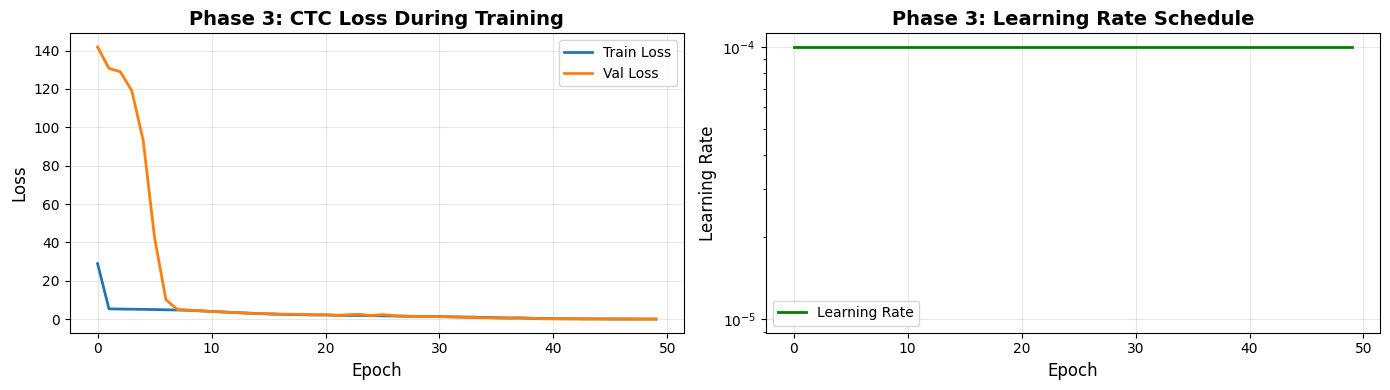


PHASE 3 TRAINING SUMMARY
Total Epochs: 50
Best Val Loss: 0.0691
Final Train Loss: 0.1033
Final Val Loss: 0.0734

TEST SET PERFORMANCE
Test Loss: 0.0953
Test Accuracy: 86.27%
Correct Predictions: 201/233

DATASET BREAKDOWN
Training Samples: 1116
  - Single-word: 438
  - 2-word: 90
  - 3-word: 421

Validation Samples: 198
Test Samples: 233
Total Samples: 1547


✅ Summary saved to C:\Users\paris\OneDrive\Desktop\Model_Traning\FingerSpelling\Foundation\logs


In [8]:
# ==============================================================================
# CELL 8: VISUALIZE TRAINING & RESULTS
# ==============================================================================

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Loss plot
axes[0].plot(history_p3.history['loss'], label='Train Loss', linewidth=2)
axes[0].plot(history_p3.history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Phase 3: CTC Loss During Training', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Learning rate (if available)
if 'lr' in history_p3.history:
    axes[1].plot(history_p3.history['lr'], label='Learning Rate', linewidth=2, color='green')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Learning Rate', fontsize=12)
    axes[1].set_title('Phase 3: Learning Rate Schedule', fontsize=14, fontweight='bold')
    axes[1].set_yscale('log')
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)
else:
    axes[1].text(0.5, 0.5, 'Learning Rate info not available', 
                ha='center', va='center', fontsize=12)

plt.tight_layout()
plt.savefig(os.path.join(LOGS_DIR, 'phase3_training_history.png'), dpi=150, bbox_inches='tight')
print(f"✅ Training history saved!")
plt.show()

# Summary statistics
summary_text = f"""
PHASE 3 TRAINING SUMMARY
{'='*60}
Total Epochs: {len(history_p3.history['loss'])}
Best Val Loss: {min(history_p3.history['val_loss']):.4f}
Final Train Loss: {history_p3.history['loss'][-1]:.4f}
Final Val Loss: {history_p3.history['val_loss'][-1]:.4f}

TEST SET PERFORMANCE
{'='*60}
Test Loss: {test_loss_p3:.4f}
Test Accuracy: {accuracy_p3:.2f}%
Correct Predictions: {correct_full}/{total_full}

DATASET BREAKDOWN
{'='*60}
Training Samples: {len(X_train_p2)}
  - Single-word: {len(X_single) * 0.85 / len(X_phase2) * len(X_train_p2):.0f}
  - 2-word: {len(X_2word) * 0.85 / len(X_phase2) * len(X_train_p2):.0f}
  - 3-word: {len(X_3word) * 0.85 / len(X_phase2) * len(X_train_p2):.0f}

Validation Samples: {len(X_val_p2)}
Test Samples: {len(X_test_p2)}
Total Samples: {len(X_phase2)}
"""

print(summary_text)

# Save summary
with open(os.path.join(LOGS_DIR, 'phase3_summary.txt'), 'w') as f:
    f.write(summary_text)

print(f"\n✅ Summary saved to {LOGS_DIR}")


In [9]:
# ==============================================================================
# CELL 9: SAVE & EXPORT MODELS & DATA
# ==============================================================================

print("\n" + "="*80)
print("SAVING ALL MODELS & DATA")
print("="*80 + "\n")

# Save Phase 3 model (already done in Cell 6, but double-check)
model_phase3.save(os.path.join(MODEL_DIR, 'phase3_final.h5'))
print(f"✅ Phase 3 Model: {os.path.join(MODEL_DIR, 'phase3_final.h5')}")

# Save word map
word_map_df = pd.DataFrame({
    'Word_ID': list(WORD_MAP.keys()),
    'Word': list(WORD_MAP.values())
})
word_map_df.to_csv(os.path.join(DATA_DIR, 'word_map.csv'), index=False)
print(f"✅ Word Map: {os.path.join(DATA_DIR, 'word_map.csv')}")

# Create metadata file
metadata = {
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'model_name': 'Phase3_SequenceRecognizer',
    'input_shape': (None, 720, 6),
    'output_shape': (None, None, 8),
    'vocab_size': 8,
    'batch_size': BATCH_SIZE,
    'epochs_trained': len(history_p3.history['loss']),
    'final_test_accuracy': float(accuracy_p3),
    'test_loss': float(test_loss_p3),
    'total_training_samples': len(X_train_p2),
    'total_test_samples': len(X_test_p2)
}

with open(os.path.join(LOGS_DIR, 'metadata.txt'), 'w') as f:
    for key, value in metadata.items():
        f.write(f"{key}: {value}\n")

print(f"✅ Metadata: {os.path.join(LOGS_DIR, 'metadata.txt')}")

print(f"\n{'='*80}")
print("ALL FILES SAVED")
print("="*80)
print(f"\nDirectory Structure:")
print(f"  {MODEL_DIR}/")
print(f"    ├── phase3_best_sequence.h5 (best model)")
print(f"    └── phase3_sequence_final.h5 (final model)")
print(f"  {LOGS_DIR}/")
print(f"    ├── phase3_training_history.png")
print(f"    ├── phase3_summary.txt")
print(f"    └── metadata.txt")
print(f"  {DATA_DIR}/")
print(f"    ├── X_train_phase2.npy")
print(f"    ├── y_train_phase2.npy")
print(f"    ├── X_val_phase2.npy")
print(f"    ├── y_val_phase2.npy")
print(f"    ├── X_test_phase2.npy")
print(f"    ├── y_test_phase2.npy")
print(f"    └── word_map.csv")



SAVING ALL MODELS & DATA

✅ Phase 3 Model: C:\Users\paris\OneDrive\Desktop\Model_Traning\FingerSpelling\Foundation\models\phase3_final.h5
✅ Word Map: C:\Users\paris\OneDrive\Desktop\Model_Traning\FingerSpelling\Foundation\data\word_map.csv
✅ Metadata: C:\Users\paris\OneDrive\Desktop\Model_Traning\FingerSpelling\Foundation\logs\metadata.txt

ALL FILES SAVED

Directory Structure:
  C:\Users\paris\OneDrive\Desktop\Model_Traning\FingerSpelling\Foundation\models/
    ├── phase3_best_sequence.h5 (best model)
    └── phase3_sequence_final.h5 (final model)
  C:\Users\paris\OneDrive\Desktop\Model_Traning\FingerSpelling\Foundation\logs/
    ├── phase3_training_history.png
    ├── phase3_summary.txt
    └── metadata.txt
  C:\Users\paris\OneDrive\Desktop\Model_Traning\FingerSpelling\Foundation\data/
    ├── X_train_phase2.npy
    ├── y_train_phase2.npy
    ├── X_val_phase2.npy
    ├── y_val_phase2.npy
    ├── X_test_phase2.npy
    ├── y_test_phase2.npy
    └── word_map.csv


In [10]:
# ==============================================================================
# CELL 10: INFERENCE PIPELINE (READY FOR PRODUCTION)
# ==============================================================================

print("\n" + "="*80)
print("PRODUCTION INFERENCE PIPELINE")
print("="*80 + "\n")

# Load saved model
print("Loading trained model...")
model_inference = keras.models.load_model(
    os.path.join(MODEL_DIR, 'phase3_sequence_final.h5'),
    custom_objects={'CTCLoss': CTCLoss}
)
print("✅ Model loaded!")

def inference_pipeline(imu_data, model=model_inference):
    """
    Complete inference pipeline
    
    Args:
        imu_data: numpy array of shape (timesteps, 6)
        model: trained Phase 3 model
    
    Returns:
        List of predicted words
    """
    # Normalize to 720 timesteps
    normalized = normalize_sequence(imu_data, target_length=720)
    
    # Add batch dimension
    batch_data = np.expand_dims(normalized, axis=0)
    
    # Get model predictions
    logits = model.predict(batch_data, verbose=0)[0]
    
    # Decode
    pred_words = decode_sequence(logits)
    
    return pred_words

# Test inference on test set
print("\nTesting inference on 5 random test samples:\n")

random_indices = np.random.choice(len(X_test_p2), 5, replace=False)

for idx in random_indices:
    pred_words = inference_pipeline(X_test_p2[idx])
    true_indices = [int(y) for y in y_test_p2[idx] if int(y) > 0]
    true_words = [WORD_MAP[i] for i in true_indices]
    
    pred_str = " ".join(pred_words)
    true_str = " ".join(true_words)
    status = "✅" if pred_words == true_words else "❌"
    
    print(f"{status} True: {true_str:40s} | Pred: {pred_str}")

print(f"\n{'='*80}")
print("INFERENCE PIPELINE READY FOR PRODUCTION!")
print("="*80)
print(f"\nUsage:")
print(f"  from Phase3_notebook import inference_pipeline")
print(f"  predicted_words = inference_pipeline(your_imu_data)")
print(f"  # Returns: ['HELLO', 'GOOD', 'MORNING']")



PRODUCTION INFERENCE PIPELINE

Loading trained model...
✅ Model loaded!

Testing inference on 5 random test samples:

✅ True: NIGHT                                    | Pred: NIGHT
✅ True: GOOD OK HOW                              | Pred: GOOD OK HOW
✅ True: MORNING YOU MORNING                      | Pred: MORNING YOU MORNING
✅ True: GOOD                                     | Pred: GOOD
✅ True: GOOD                                     | Pred: GOOD

INFERENCE PIPELINE READY FOR PRODUCTION!

Usage:
  from Phase3_notebook import inference_pipeline
  predicted_words = inference_pipeline(your_imu_data)
  # Returns: ['HELLO', 'GOOD', 'MORNING']
